## Projeto Integrador

Importando bibliotecas

In [94]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.models import Sequential #inicio da rede neural, permite montar as camadas
from tensorflow.keras.layers import Dense #permite criar camadas densamente conectadas
from tensorflow.keras.layers import Dropout #permite criar a camada de regulariação da rede
from tensorflow.keras.layers import Flatten #operação de achatamento da rede
from tensorflow.keras.layers import Conv2D #convolução dos dados de entrada (pode existir mais de uma camada na rede)
from tensorflow.keras.layers import MaxPooling2D  #camada de ajustamento 
from tensorflow.keras import backend as K 
from tensorflow.keras.layers import BatchNormalization

K.set_image_data_format("channels_last")


import numpy as np
import pandas as pd
import cv2
import os
import skimage
from skimage import io
from PIL import Image
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

import matplotlib.pyplot as plt
%matplotlib inline 

seed = 42 
np.random.seed(seed) 

Importando bases de treino e teste (balanced MNIST)

In [95]:
train = pd.read_csv('C:/Users/hallo/Documents/Turma_03/notebooks/Projeto integrador/emnist-balanced-train.csv')
test = pd.read_csv('C:/Users/hallo/Documents/Turma_03/notebooks/Projeto integrador/emnist-balanced-test.csv')

## Tratamento da base

In [96]:
from tensorflow.keras.utils import to_categorical
#definindo y da base de treino, transformando em categórica
y_train = train.iloc[:,0]
y_train = to_categorical(y_train)
print("y_train:", y_train.shape)

#definindo y da base de teste, transformando em categórica
y_test = test.iloc[:,0]
y_test = to_categorical(y_test)
print("y_test:", y_test.shape)

y_train: (112799, 47)
y_test: (18799, 47)


In [97]:
#rotação das imagens
def rotate(image):
    image = image.reshape([28, 28])
    image = np.fliplr(image)
    image = np.rot90(image)
    return image

In [98]:
#definindo x da base de treino e teste
x_train = train.iloc[:,1:]
x_test = test.iloc[:,1:]

# transformando X_train e x_test em arrays
x_train = np.asarray(x_train)
x_test = np.asarray(x_test)

# rotacionando a imagem
x_train = np.apply_along_axis(rotate, 1, x_train)
x_test = np.apply_along_axis(rotate, 1, x_test)

# normalizando as bases
x_train = x_train.astype('float32')
x_train /= 255
print("x_train:",x_train.shape)

x_test = x_test.astype('float32')
x_test /=255
print("x_test:",x_test.shape)

x_train: (112799, 28, 28)
x_test: (18799, 28, 28)


In [99]:
#fazendo o ajuste para cinza e escala 28vs28
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32')
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32')
print(x_train.shape)
print(x_test.shape)

(112799, 28, 28, 1)
(18799, 28, 28, 1)


In [100]:
#definindo número de classes
num_class = 47

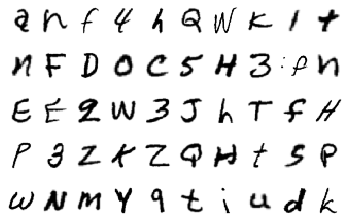

In [101]:
#visualizando dados
idx = 0
for i in range(50):
    plt.subplot(5, 10, idx+1)
    plt.imshow(
        x_train[idx].reshape(28,28), 
        cmap='gray_r', #transforma em escala de cinza invertido com o fundo branco
        interpolation='nearest'
    )
    plt.axis('off') #retira os eixos de cada figura
    idx += 1

## Rede Neural (cnn)

In [102]:

model = Sequential()
#primeira camada convulsional
model.add(Conv2D(filters=128, kernel_size=(5,5), padding = 'same', activation='relu',input_shape=(28, 28, 1)))
#camanda de ajustamento
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
#segunda camada convulsional
model.add(Conv2D(filters=64, kernel_size=(3,3) , padding = 'same', activation='relu'))
#camada de ajustamento
model.add(MaxPooling2D(pool_size=(2,2)))
# camada que achata o array para uma única coluna, converte o tensor
model.add(Flatten())
#camada densamente conectada com 128 neuronios
model.add(Dense(units=128, activation='relu'))
#camada de regularização para rede 
model.add(Dropout(.5))
#saída com a distribuição de probabilidades de cada classe
model.add(Dense(units=num_class, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 128)       3328      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        73792     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               401536    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)              

In [103]:
#camada para consolidar a arquitetura da rede neural (utiliza a entropia cruzada)
optimizer = keras.optimizers.Adam(learning_rate = 0.01)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [104]:
#distribuição de treino e valiação
train_x, val_x, train_y, val_y = train_test_split(x_train, y_train, test_size= 0.10, random_state=7)

In [105]:
#treino da rede  (testar performance do modelo). Por 10 vezes os exemplos serão expostos, em lotes de tamanho 512
history = model.fit(train_x, train_y, epochs=10, batch_size=512, verbose=1, validation_data=(val_x, val_y))

Epoch 1/10
199/199 [==============================] - 245s 1s/step - loss: 1.5804 - accuracy: 0.5521 - val_loss: 0.5628 - val_accuracy: 0.8153
Epoch 2/10
199/199 [==============================] - 286s 1s/step - loss: 0.7526 - accuracy: 0.7628 - val_loss: 0.4575 - val_accuracy: 0.8437
Epoch 3/10
199/199 [==============================] - 236s 1s/step - loss: 0.6150 - accuracy: 0.8000 - val_loss: 0.4058 - val_accuracy: 0.8578
Epoch 4/10
199/199 [==============================] - 274s 1s/step - loss: 0.5481 - accuracy: 0.8208 - val_loss: 0.3829 - val_accuracy: 0.8653
Epoch 5/10
199/199 [==============================] - 210s 1s/step - loss: 0.5042 - accuracy: 0.8320 - val_loss: 0.3711 - val_accuracy: 0.8685
Epoch 6/10
199/199 [==============================] - 170s 854ms/step - loss: 0.4755 - accuracy: 0.8402 - val_loss: 0.3614 - val_accuracy: 0.8676
Epoch 7/10
199/199 [==============================] - 168s 845ms/step - loss: 0.4523 - accuracy: 0.8483 - val_loss: 0.3542 - val_accuracy: 

In [106]:
from datetime import datetime

now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)


Current Time = 18:25:56


In [107]:
#score encontrado pela rede neural para o dataset de teste
scores = model.evaluate(x_test, y_test, verbose=0)
print("\nacc: %.2f%%" % (scores[1]*100))


acc: 87.72%


## Previsões da rede (base test)

In [108]:
# prevendo os cinco primeiros digitos e printando as previsões e as labels corretas
pred = model.predict(x_test[:5]) 
pred = np.argmax(pred, axis = 1)[:5] 
label = np.argmax(y_test,axis = 1)[:5] 

print(pred) 
print(label)

[39  9 26  9 33]
[39  9 26 44 33]


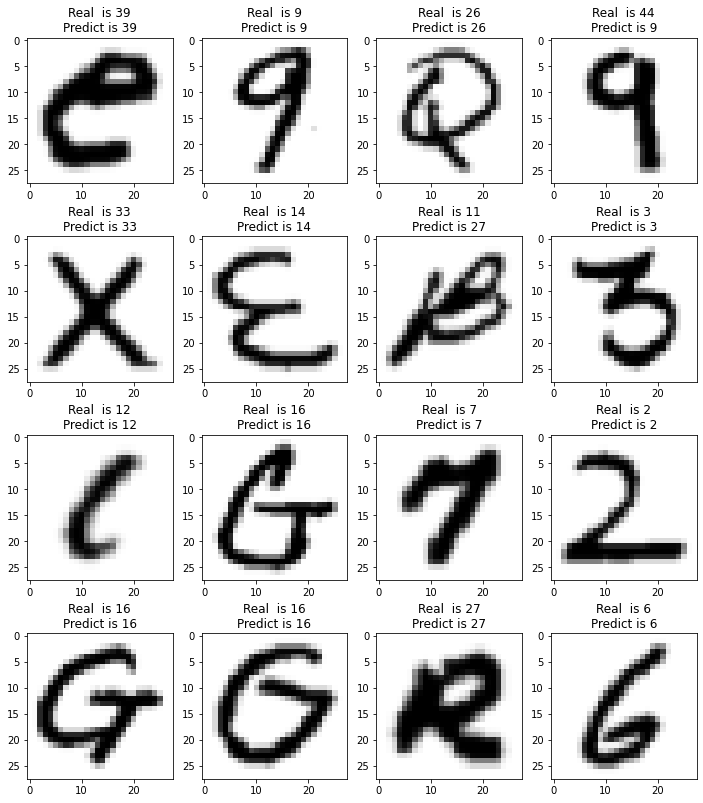

In [109]:
#visualizando primeiras previsões, em formato de imagem
y_pred = model.predict_classes(x_test)
x_test__ = x_test.reshape(x_test.shape[0], 28, 28)
fig, axis = plt.subplots(4, 4, figsize=(12, 14))


for i, ax in enumerate(axis.flat):
    ax.imshow(x_test__[i], cmap='binary')
    ax.set(title = f"Real  is {y_test[i].argmax()}\nPredict is {y_pred[i]}");
    

## Análise da validação

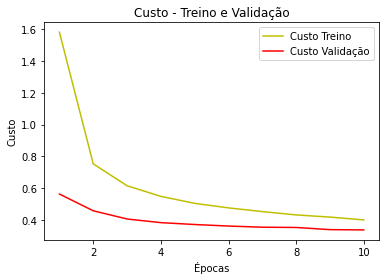

In [110]:
# graficando a queda da função de custo através das épocas
custo = history.history['loss']
validacao_custo = history.history['val_loss']
epocas = range(1, len(custo) + 1)
plt.plot(epocas, custo, 'y', label='Custo Treino')
plt.plot(epocas, validacao_custo, 'r', label='Custo Validação')
plt.title('Custo - Treino e Validação')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()

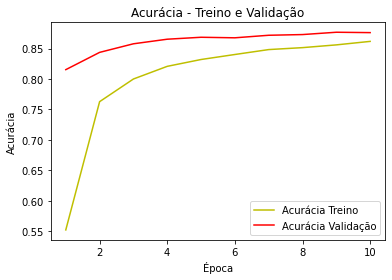

In [111]:
acuracia = history.history['accuracy']
validacao_acuracia = history.history['val_accuracy']
plt.plot(epocas, acuracia, 'y', label='Acurácia Treino')
plt.plot(epocas, validacao_acuracia, 'r', label='Acurácia Validação')
plt.title('Acurácia - Treino e Validação')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

## Inserindo nova imagem para previsão

In [112]:
#importando bibliotecas
from skimage import io
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.color import rgb2gray
import numpy as np

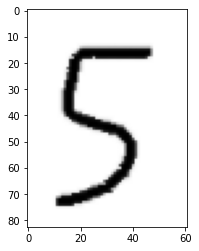

In [113]:
#importando imgagem
img = io.imread('C:/Users/hallo/Documents/Turma_03/notebooks/Projeto integrador/Tentativa keras/number-five.png')
plt.imshow(img)

In [114]:
img.shape

(83, 61, 4)

In [115]:
#ajustando imagem para o padrão da rede
img_gray = rgb2gray(img)
img_size = resize(img_gray,(28,28))
img_reshape = (img_size.reshape(-1, 28, 28, 1).astype('float32'))/255
img_reshape.shape

c:\users\hallo\documents\turma_03\envs\mod0\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  


(1, 28, 28, 1)

In [116]:
#realizando previsão
pred = model.predict_classes(img_reshape)
pred

array([18], dtype=int64)

Nota-se que a rede não previu corretamente a nova imagem inserida apesar do bom nível de acurácia do modelo. Esse aspecto é recorrente no uso das redes convolucionais (CNN) e objeto de estudo de acadêmicos e cientistas. Para estressar o modelo será realizado um experimento: criar uma alteração em uma das imagens de teste que a rede acertou a previsão, e submeté-la ao modelo (teste de reuído).

## Teste de ruído

In [131]:
#criando uma imagem de ruído, com preenchimento aleatório e mudança sutil
nova_img=np.random.rand(28,28,1) * 0.01
nova_img

array([[[6.23859325e-03],
        [4.51767679e-03],
        [5.86608463e-03],
        [1.68014208e-03],
        [7.36873745e-03],
        [8.62797078e-03],
        [2.16739800e-03],
        [9.57145555e-04],
        [2.36385860e-04],
        [6.41971500e-03],
        [6.07094036e-03],
        [5.46697413e-03],
        [2.31947096e-03],
        [3.90905996e-03],
        [5.94476335e-03],
        [4.96766859e-03],
        [9.87785520e-03],
        [1.36439753e-03],
        [6.95144554e-03],
        [4.04318768e-03],
        [4.28199615e-03],
        [7.17597766e-03],
        [6.92436151e-03],
        [9.91255994e-03],
        [1.28394289e-03],
        [1.04109649e-03],
        [7.24338817e-03],
        [5.78386917e-03]],

       [[2.74160667e-03],
        [7.94193690e-04],
        [8.56582496e-04],
        [8.94190875e-03],
        [1.91867325e-03],
        [3.23371562e-03],
        [2.26656402e-03],
        [3.54996306e-03],
        [6.94238427e-04],
        [5.19059791e-03],
        [6

In [132]:
#visualizando o shape da imagem de ruído
nova_img.shape

(28, 28, 1)

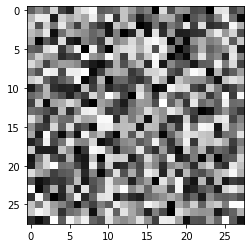

In [143]:
#imagem de ruído
#simplificando dimensõe para plotar o gráfico do ruído (squeeze)
plt.imshow(np.squeeze(nova_img),cmap='binary')

In [155]:
# foi selecionada a letra B da base de teste (previsão que a rede acertou)
x_test[27].shape


(28, 28, 1)

In [156]:
#transpondo imagem de ruído com a letra B (para que seja gerada uma nova imagem que apresenta pequenas mudanças)
img_transposta = x_test[27] + nova_img
img_transposta.shape

(28, 28, 1)

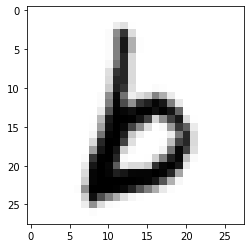

In [157]:
#plot da imagem escolhida
plt.imshow(np.squeeze(x_test[27]),cmap='binary')

In [158]:
#visualizando a imagem resultante (transposta)
img_transposta

array([[[6.23859325e-03],
        [4.51767679e-03],
        [5.86608463e-03],
        [1.68014208e-03],
        [7.36873745e-03],
        [8.62797078e-03],
        [2.16739800e-03],
        [9.57145555e-04],
        [2.36385860e-04],
        [6.41971500e-03],
        [6.07094036e-03],
        [5.46697413e-03],
        [2.31947096e-03],
        [3.90905996e-03],
        [5.94476335e-03],
        [4.96766859e-03],
        [9.87785520e-03],
        [1.36439753e-03],
        [6.95144554e-03],
        [4.04318768e-03],
        [4.28199615e-03],
        [7.17597766e-03],
        [6.92436151e-03],
        [9.91255994e-03],
        [1.28394289e-03],
        [1.04109649e-03],
        [7.24338817e-03],
        [5.78386917e-03]],

       [[2.74160667e-03],
        [7.94193690e-04],
        [8.56582496e-04],
        [8.94190875e-03],
        [1.91867325e-03],
        [3.23371562e-03],
        [2.26656402e-03],
        [3.54996306e-03],
        [6.94238427e-04],
        [5.19059791e-03],
        [6

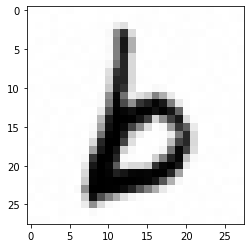

In [163]:
#plot da imagem onde foi adicionado o ruído
plt.imshow(np.squeeze(img_transposta),cmap='binary')

In [164]:
#ajustando o tamanho da nova imagem gerada, para o tamanho da rede
img_reshape2 = (img_transposta.reshape(-1, 28, 28, 1).astype('float32'))/255
img_reshape2.shape

(1, 28, 28, 1)

In [162]:
#realizando a previsão 
pred2 = model.predict_classes(img_reshape2)
pred2

array([18], dtype=int64)

Nota-se que novamente a rede não foi capaz de realizar a previsão correta, reforçando o ponto destacado anteriormente sobre os limites do modelo e desafios no desenvolvimento dessa tecnologia.